## <b> Modeling Insights </b> notebook (Nr 4) for <b>Project 2</b> of General Assembly DSIR-0320 
by Martijn de Vries </br>
martijndevries91@gmail.com

## Problem Statement

A real estate company in Ames, Iowa is looking for a new and improved way to evaluate the market value of a house. Using the Ames data set as training data, we will build a predictive linear regression model to predict the sale price of a house as well as possible.

To gauge the model performance, I will compare my results against a 'benchmark model', which is a simple OLS regression of total living area versus sale price. How much can a more complex model improve over this simple basic model? I will try out different models with different numbers of features using different linear regression techniques, and ultimately identify which model does the best job at predicting the market value of the house.

## In this notebook

In the previous Modeling notebook I fit a bunch of different models using different strategies and regressors. In this notebook, I want to further investigate the best model, compare it to the benchmark model, figure out what worked and what didn't, and then finally give some general conclusions.

In the previous notebook we saw that the most complex model, model 4, seems to give the best predictions - for both an OLS regression and Ridge Regression (and when combined with a log-transform of the Sale Price). So let's start this notebook by making a data dictionary of the features of the most succesful model, then refit the model using statsmodels and use the summary() method to evaluate the P-value scores of different parameters.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tools import tools
import statsmodels.api as sm
import scipy.stats as stat

#sklearn imports
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline

## Data Dictionary 

A data dictionary of the features used in the most succesful model. All features are from the Ames housing data set - 'Feature engineered' indicates that additional processing was done to the columns before inputting them into the model.

|Feature|Type|Dataset|Description|Encoding Info|
|---|---|---|---|---|
|ID | int | Ames data | ***Primary Key***-The house ID in the Ames housing data set || 
|tot_area | float | Feature Engineered | The total living area in square feet|Sum of above-grade SF and basement SF|
|gar_area| float | Ames data | the Garage area in square feet ||
|lot_frontage | float | Ames data | the total amount of lot frontage in linear feet| 
|yr_built | int | Ames data | the year the house was built | |
|yr_remod | int | Ames data | the year the house was remodeled or added to | |
|qual | int | Ames data | The overall quality rating of the house | rated 1-10|
|tot_rooms_abv | int | Ames data | The total number of rooms above ground | |
|full_bath | int | Ames data | the total number of bathrooms | |
|mas_vnr_area | float | Ames data | the total surface area of masonry veneer  | |
|fireplaces | int | Ames data | the total number of fireplaces ||
|cond | int | Ames data | The overall condiiton rating of the house  | rated 1-10|| 
|gar_cars | int | Ames data | The number of cars that fit into the garage ||
|cond_\*\*\* | category | Feature engineered | Special conditions that apply to the house | Dummified: 'Typ' rating is baseline |
|MS Zoning_\*\*\* | category | Feature enginereed | Zoning code for the house (eg Residential, industrial) | Dummified: 'RL' is the baseline
|Func_\*\*\*  | category | Feature engineered | Functionality for the house (eg. deductions, salvage) | Dummified: 'Typ' is the baseline
|Neighborhood_\*\*\* | category | Feature engineered | Neighborhood | Dummified: 'NAmes' is the baseline |
|Kitchen Qual_\*\*\* | category | Feature engineered | Quality rating of the kitchen (good, poor, fair, etc) |  Dummified: 'TA' is the baseline
|Bsmt Qual_\*\*\* | category | Feature engineered | Quality rating of the basement (good, poor, fair, etc) |  Dummified: 'TA' is the baseline
|Central Air_\*\*\* | category | Feature engineered | Whether the house has central air conditioning or not |  Dummified: 'Y' is the baseline
|Alley_\*\*\* | category | Feature engineered | Whether the house has an alley and what type |  Dummified: 'NP' is the baseline
|Paved Drive_\*\*\* | category | Feature engineered | Is there a paved driveway |  Dummified: 'Y' is the baseline
|Saleprice | int |Ames data | ***Target variable***-the sale price in dollars | I use log(Saleprice) in the actual regression |




## The best model

In [2]:
def print_metrics(r_obj, X_train, X_val, y_train, y_val, islog=False):
    """
    for a given regression object, and input training/validation data, print out 1) the r2 score, 2) the cross-validation score of the training data, and 
    3) the RMSE for both the training and validation data
    assumes y-values are not log transformed. if islog=True, the log transformation happens within this function
    """
    
    if islog == False:
        train_score = r_obj.score(X_train, y_train)
        val_score = r_obj.score(X_val, y_val)
    elif islog == True:
        train_score = r_obj.score(X_train, np.log(y_train))
        val_score = r_obj.score(X_val, np.log(y_val))
    print(f'The training r2 score is {str(train_score)}')
    print(f'The validation r2 score is {str(val_score)}')

    if islog == False:
        crossval = np.average(cross_val_score(r_obj, X_train, y_train))
    elif islog == True:
        crossval = np.average(cross_val_score(r_obj, X_train, np.log(y_train)))
    
    print(f'The cross validation score is {str(crossval)}')
    print('-'*60)
                
    preds_train = r_obj.predict(X_train)
    preds_val = r_obj.predict(X_val)
    
    #RMSE in dollars
    if islog == False:
        rmse_val =  mean_squared_error(y_val, preds_val, squared=False)
        rmse_train =  mean_squared_error(y_train, preds_train, squared=False)
    elif islog == True:
        rmse_val =  mean_squared_error(y_val, np.exp(preds_val), squared=False)
        rmse_train =  mean_squared_error(y_train, np.exp(preds_train), squared=False)
        
    print(f'The training RMSE score is {str(rmse_train)}')
    print(f'The validation RMSE score is {str(rmse_val)}')
    
    return

In [3]:
#load in the feature engineered training data for model 4
#this model 
df_model4= pd.read_csv('../model_inputs/train_engineered_m4.csv')
df_model4.head()

,Id,tot_area,gar_area,lot_frontage,yr_built,yr_remod,qual,tot_rooms_abv,full_bath,mas_vnr_area,...,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_NP,Bsmt Qual_Po,Central Air_N,Alley_Grvl,Alley_Pave,Paved Drive_N,Paved Drive_P,SalePrice
0,109,2204.0,475.0,89.778892,1976,2005,6,6,2,289.0,...,0,0,0,0,0,0,0,0,0,130500
1,544,3035.0,559.0,43.000000,1996,1997,7,8,2,132.0,...,0,1,0,0,0,0,0,0,0,220000
2,153,2114.0,246.0,68.000000,1953,2007,5,5,1,0.0,...,0,0,0,0,0,0,0,0,0,109000
3,318,1828.0,400.0,73.000000,2006,2007,5,7,2,0.0,...,0,1,0,0,0,0,0,0,0,174000
4,255,2121.0,484.0,82.000000,1900,1993,6,6,2,0.0,...,1,0,0,0,0,0,0,1,0,138500


In [4]:
df_model4.dtypes

Id                 int64
tot_area         float64
gar_area         float64
lot_frontage     float64
yr_built           int64
                  ...   
Alley_Grvl         int64
Alley_Pave         int64
Paved Drive_N      int64
Paved Drive_P      int64
SalePrice          int64
Length: 71, dtype: object

In [5]:
X = df_model4.drop(columns=['Id', 'SalePrice'])
y = df_model4['SalePrice']
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)

In [6]:
#Fit with sklearn
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))
print_metrics(lr, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9205086047396134
The validation r2 score is 0.8830169861886302
The cross validation score is 0.908501590825022
------------------------------------------------------------
The training RMSE score is 21674.95646074773
The validation RMSE score is 22312.439659127


In [7]:
X_train_c = tools.add_constant(X_train)
model = sm.OLS(np.log(y_train),X_train_c).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     249.7
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:54:34   Log-Likelihood:                 1149.9
No. Observations:                1535   AIC:                            -2162.
Df Residuals:                    1466   BIC:                            -1794.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.6283      0.647      7.154      0.000       3.359       5.897
tot_area                 0.0002   8.57e-06     22.729      0.000       0.000       0.000
gar_area                 0.0001   3.59e-05      4.109      0.000    7.71e-05       0.000
lot_frontage             0.0006      0.000      3.763      0.000       0.000       0.001
yr_built                 0.0021      0.000      7.381      0.000       0.002       0.003
yr_remod                 0.0010      0.000      3.977      0.000       0.000       0.001
qual                     0.0538      0.004     12.447      0.000       0.045       0.062
tot_rooms_abv            0.0110      0.003      3.688      0.000       0.005       0.017
full_bath                0.0018      0.008      0.206      0.837      -0.015       0.018
mas_vnr_area          2.417e-05   2.17e-05      1.114      0.266   -1.84e-05    6.68e-05
fireplaces               0.0550      0.006      9.119      0.000       0.043       0.067
cond                     0.0458      0.004     12.003      0.000       0.038       0.053
gar_cars                 0.0053      0.010      0.514      0.607      -0.015       0.025
cond_RRAe               -0.0813      0.029     -2.817      0.005      -0.138      -0.025
cond_PosA                0.0627      0.038      1.634      0.102      -0.013       0.138
cond_Artery             -0.0417      0.018     -2.379      0.018      -0.076      -0.007
cond_Feedr              -0.0350      0.015     -2.409      0.016      -0.064      -0.007
cond_PosN                0.0326      0.029      1.141      0.254      -0.023       0.089
cond_RRAn                0.0226      0.023      0.986      0.324      -0.022       0.068
cond_RRNe               -0.0917      0.084     -1.088      0.277      -0.257       0.074
cond_RRNn               -0.0280      0.054     -0.520      0.603      -0.134       0.078
MS Zoning_C (all)       -0.2481      0.041     -6.051      0.000      -0.328      -0.168
MS Zoning_FV             0.0747      0.028      2.669      0.008       0.020       0.130
MS Zoning_I (all)       -0.1008      0.123     -0.821      0.412      -0.342       0.140
MS Zoning_RH             0.0419      0.040      1.041      0.298      -0.037       0.121
MS Zoning_RM            -0.0418      0.016     -2.546      0.011      -0.074      -0.010
Func_Maj                -0.1805      0.033     -5.456      0.000      -0.245      -0.116
Func_Min                -0.0070      0.016     -0.433      0.665      -0.039       0.025
Func_Mod                -0.0596      0.027     -2.217      0.027      -0.112      -0.007
Func_Sev                -0.4492      0.085     -5.271      0.000      -0.616      -0.282
Neighborhood_Blmngtn    -0.0445      0.033     -1.343      0.179      -0.110       0.021
Neighborhood_Blueste    -0.0727      0.052     -1.395    

It seems that the numerical columns (ie not categorical dummy columns) with the highest P-values (that is, the probability that these parameters are just fit to noise) are Garage Cars and Full Bath. Will the model get better if I get rid of those?

In [8]:
X = df_model4.drop(columns=['Id', 'SalePrice', 'full_bath', 'gar_cars'])
y = df_model4['SalePrice']
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)

In [9]:
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))

LinearRegression()

In [10]:
print_metrics(lr, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9204911110079034
The validation r2 score is 0.8827456064942821
The cross validation score is 0.9085772206180296
------------------------------------------------------------
The training RMSE score is 21673.07742284863
The validation RMSE score is 22314.573728817486


It seems the model is virtually the same, maybe slightly worse. So that doesn't really help. 

Overall, most parameters have high t-scores and low P-values (although not every individual Dummy column does). We can see that the total area is the most important feature and certainly makes the most sense as the beginning point of any model of housing prices, but from the t-scores and P-values we can see that the vast majority of features I selected add significant predictive power to the model.

From the modeling notebook, it appear that the slightly better model might actually the Ridge regression model (although the difference with ordinary linear regression is pretty marginal). Let's focus on that particular model:

In [11]:
#scale data and apply a Ridge model
pipe = make_pipeline(StandardScaler(), Ridge(alpha=1))
pipe.fit(X_train, np.log(y_train))

print_metrics(pipe, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9204908418796016
The validation r2 score is 0.88273725203526
The cross validation score is 0.9085970407043058
------------------------------------------------------------
The training RMSE score is 21672.57036662563
The validation RMSE score is 22310.694330116545


Although I steadily increased the modeling complexity in the different model iterations, it seems that this model is still not overfit. There is a good agreement between the r2-scores of the training and validation set, and the cross-validation score agrees well with the training score too. The overall score is high. At the same time, we did see in the modeling notebook that adding a lot of extra features (between models 2/3, and 4) only modestly increased the model performance. I would say that this model likely sits pretty close to the sweet spot in the bias-variance tradeoff.

One caveat: the validation data was part of the training data and is only set aside right here. So there is a bit of a <i>data leakage</i> issue here - the data was cleaned, imputed, and feature engineered all together. However, we also have the actual test set to compare against, and this model scored an RMSE of 21504 on Kaggle. So it seems that overall my model performs just as well on completely unseen data. In fact, it actually does slightly better against the testing set than against the validation set - which I think is because of those few outliers in the validation set (see the residual plot below) that add a lot to the RMSE.

## LINEM assumptions and Comparison to benchmark

Do the LINEM assumptions hold for this model? We can re-inspect the residual plot, as well as a qq plot to see how the residuals are distributed

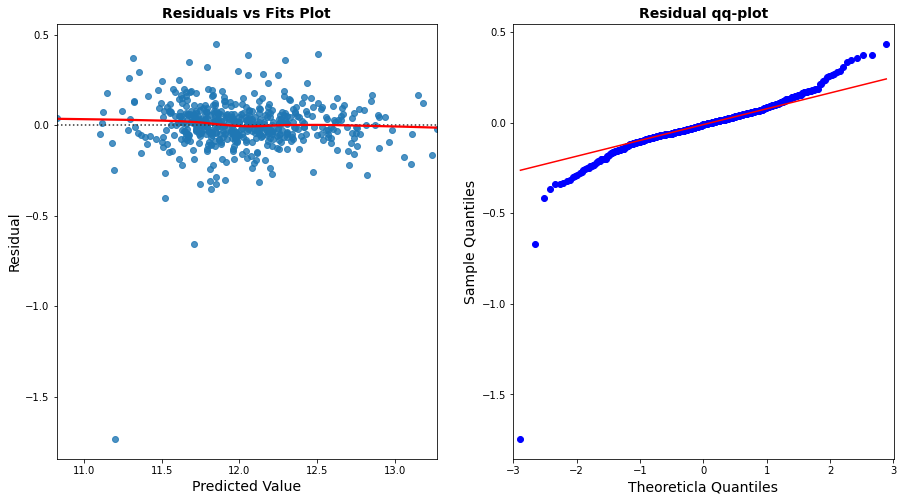

In [12]:
preds_val = lr.predict(X_val)
resids = np.log(y_val) - preds_val
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
sns.residplot(x = preds_val,
              y = resids,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'}, ax=ax1)
ax1.set_title('Residuals vs Fits Plot', fontsize=14, fontweight='bold')
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_xlabel('Predicted Value', fontsize=14)

sm.qqplot(resids, dist=stat.norm, ax=ax2, line='q')
ax2.set_xlabel('Theoreticla Quantiles', fontsize=14)
ax2.set_ylabel('Sample Quantiles', fontsize=14)
ax2.set_title('Residual qq-plot', fontsize=14, fontweight='bold')
plt.show()

We can see that with the log-transformed sale price, the linearity assumption is actually fairly reasonable. It does make intuitive sense that a log-transform would work well here, given how right-skewed the sale price distribution was to begin with. In the feature engineering notebook, we also saw a few features that seemed to correlated particularly well with the log of saleprice (notably 'yr_built' and 'yr_remod'). 

The equal variance of errors condition seems to be somewhat satisfied as well, given that the errors are scattered somewhat randomly about the mean through most of the predicted value range. However, there is that egregious massive outlier around a predicted value of 11.1 (predicted value around 67k dollars). Similarly, the errors are <i>somewhat</i> normally distributed, at least within the first 1.5-2 quantiles or so. 

The condition that I violated the most is multi-collinearity. The statsmodels .describe() function I called above suggests as much as well. I did not take particular care to select features that were orthogonal to each other. In the above model, some features, like gar_area and gar_cars will certainly be strongly correlated. However, since I set out to build a predictive rather than an inferential model, this is not necessarily a big problem.

As the benchmark model, we set a simple OLS regression model of total living area to sale price. Looking at the metrics of this model again:

In [13]:
X_b = df_model4[['tot_area']]
y_b = df_model4['SalePrice']
X_train_b, X_val_b, y_train_b, y_val_b= train_test_split(X_b, y_b, random_state=42)
lr_b = LinearRegression()
lr_b.fit(X_train_b,y_train_b)

print_metrics(lr_b, X_train_b, X_val_b, y_train_b, y_val_b,islog=False)

The training r2 score is 0.6943023042761038
The validation r2 score is 0.6387963066523947
The cross validation score is 0.6918200458030501
------------------------------------------------------------
The training RMSE score is 43672.87991366827
The validation RMSE score is 47900.07573530223


The total living area does a lot of heavy lifting - by itself it is able to explain about 63% of the variance of the model, according to the R2-score on the validation set. Even so, it is clear that adding more features (in total: 11 additional numerical ones, and 9 categorical ones, each dummified) leads to a model that is significantly better - the features in the complex model can explain about 88% of the total variance, an improvement of 25%. The RMSE (measured on the validation data) is also significantly better, going from 47900 dollars for the benchmark model to 22300 dollars from the complex model, a reduction in RMSE of more than 53%.

## Why did feature engineering adjusted parameters not work?

One of the things I attempted to do in the feature engineering notebook was create 'adjusted' columns for features like the garage area, number of fireplaces, and the masonry veneer area. The idea being that eg. the surface area of the garage should count for more if the garage is in excellent, rather than poor condition. This was an attempt to encode more information in a single feature, rather than needing to create many extra dummified columns for categorical features. It is very similar to the idea of interaction features, except that with categorical features the numerical value of a category isn't necessarily obvious (What is a Garage surface area of 200 SF multiplied by a 'Good' Garage rating?). In the feature engineering notebook, I tried to quantify how much these different categories should affect the base values, and I applied this procedure to models 1 and 2.

However, it turns out using a model with those adjusted values is actually slightly worse than not adjusting them. Why is this? Below I'll make pairplots for the 3 adjusted features versus their unadjusted versions:

In [14]:
gar_area = df_model4['gar_area']
logprice = np.log(df_model4['SalePrice'])
adj_gar_area =  pd.read_csv('../model_inputs/train_engineered_m2.csv')['gar_adj_area']

df_t = pd.concat([gar_area, adj_gar_area, logprice], axis=1)

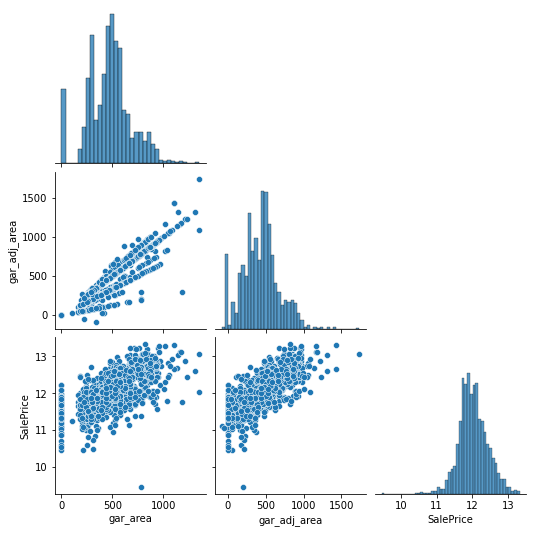

In [15]:
sns.pairplot(df_t, corner=True);

What about adj mas vnr area?

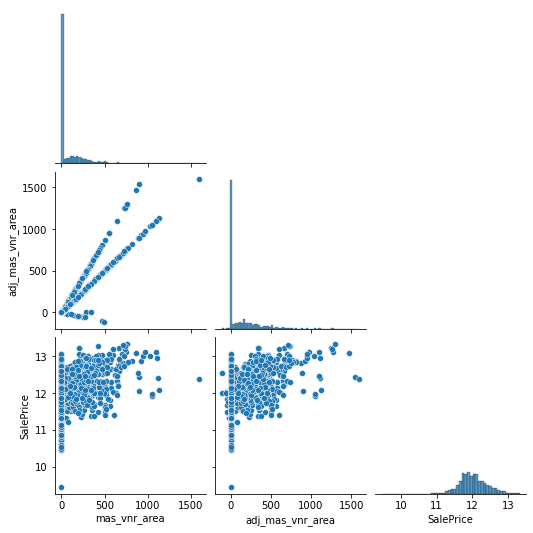

In [16]:
mas_vnr_area = df_model4['mas_vnr_area']
adj_vnr_area =  pd.read_csv('../model_inputs/train_engineered_m2.csv')['adj_mas_vnr_area']

df_t = pd.concat([mas_vnr_area, adj_vnr_area, logprice], axis=1)
sns.pairplot(df_t, corner=True);

And Fireplaces?

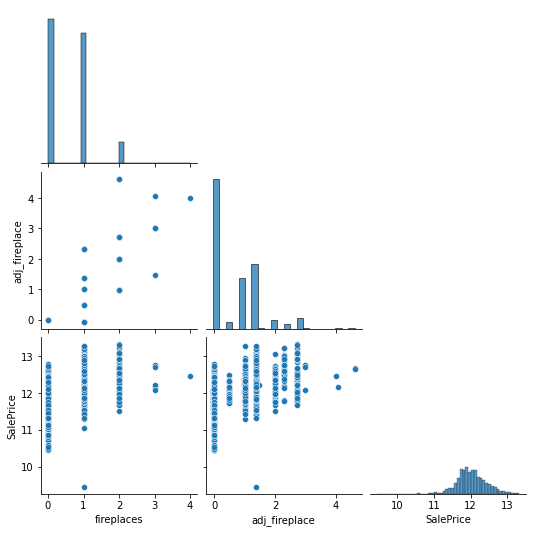

In [17]:
fireplace = df_model4['fireplaces']
adj_fireplace =  pd.read_csv('../model_inputs/train_engineered_m2.csv')['adj_fireplace']

df_t = pd.concat([fireplace, adj_fireplace, logprice], axis=1)
sns.pairplot(df_t, corner=True);

Although nothing particularly stands out from these pairplots, I think that probably the method I used to adjust the parameters was a little too crude. I tried to calculate the difference in saleprice of different categories, and calculated 'adjustment coefficients' based on that. But I ignored the fact that there might be many other dependencies hidden in there. For example, I tried to calculate how much more expensive 'excellent' garages are on compared to 'good' or 'poor' garages. But it may very well be that excellent garages are also typically larger, have more cars in them, etc, which would make the sale price larger as well. It would be very difficult to isolate the effect of a single parameter without doing a full-on regression. Which is what I was trying to avoid - I wanted to have this figured out before doing the actual modeling.

All together, my sense is that the 'adjusted' features basically just added slightly more noise and therefore made the models slightly worse.


One potentially useful tool related to feature engineering that I haven't really explored in this project are Polynomial features. It might be that ultimately this is a better way to model some of these interdependent features (related to eg. Kitchen, Garage, Basement). Given that there were already so many features to explore in this dataset, I was hesitant to add more through these kind of interaction terms. But it may well be that adding such polynomial features would improve the model.

## Conclusions

In this project, I've built a predictive linear regression model to predict the sale price of houses in Ames, Iowa using the Ames dataset.

After basic EDA and data cleaning (imputing values as appropriate), I constructed several different models of increasing complexity. The best-performing model is the most complex of the models I've constructed, consisting of 12 numerical features and 9 (dummified) categorical features. I did find that adding even more features to some extent leads to diminishing returns, in that the R2-value and root mean squared error (RMSE) of my most complex model was only modestly better than the model one step lower in complexity.

OLS and Ridge regressors performed very similar, but it seems that the Ridge regression does slightly better overall. Our model works well for predictive purposes, significantly improving over the baseline model (a simple least squares regression using total living area as the only feature). In terms of the R2-score, the features in the more complex model can explain 88% of the variance (vs 63% for the baseline), and the RMSE reduces from 47000 to 22300 dollars.

The model could likely be improved with better feature engineering: a more detailed analysis of which features should be included, and/or smarter encoding of categorical features could reduce the model complexity while still retaining the same level of predictive power. The scope of this project was limited to Linear Regression, but other type of regressions might improve the model performance well.